In [1]:
!git clone https://github.com/Pu-Zeng/696-Milestone.git

Cloning into '696-Milestone'...
remote: Enumerating objects: 3047, done.
remote: Counting objects: 100% (3047/3047), done.
remote: Compressing objects: 100% (2554/2554), done.
remote: Total 3047 (delta 55), reused 3029 (delta 37), pack-reused 0
Receiving objects: 100% (3047/3047), 34.67 MiB | 19.09 MiB/s, done.
Resolving deltas: 100% (55/55), done.


In [2]:
!pip install mlxtend

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_val_predict, StratifiedKFold
import time

In [4]:
# !pip install mlxtend

## Data Loading and Exploration

In [5]:
data = pd.read_csv('/content/696-Milestone/Toy_Dataset/spotify_songs_toy.csv')

In [6]:
data.head() # Take a quick look at our data

,Unnamed: 0,track_id,track_name,track_artist,lyrics,track_popularity,track_album_id,track_album_name,track_album_release_date,playlist_name,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,language
0,0,0017A6SJgTbfQVU2EtsPNo,Pangarap,Barbie's Cradle,Minsan pa Nang ako'y napalingon Hindi ko alam ...,41,1srJQ0njEQgd8w4XSqI4JQ,Trip,2001-01-01,Pinoy Classic Rock,...,-10.068,1,0.0236,0.27900,0.01170,0.0887,0.566,97.091,235440,tl
1,1,004s3t0ONYlzxII9PLgU6z,I Feel Alive,Steady Rollin,"The trees, are singing in the wind The sky blu...",28,3z04Lb9Dsilqw68SHt6jLB,Love & Loss,2017-11-21,Hard Rock Workout,...,-4.739,1,0.0442,0.01170,0.00994,0.3470,0.404,135.225,373512,en
2,2,00chLpzhgVjxs1zKC9UScL,Poison,Bell Biv DeVoe,"NA Yeah, Spyderman and Freeze in full effect U...",0,6oZ6brjB8x3GoeSYdwJdPc,Gold,2005-01-01,"Back in the day - R&B, New Jack Swing, Swingbe...",...,-7.504,0,0.2160,0.00432,0.00723,0.4890,0.650,111.904,262467,en
3,3,00cqd6ZsSkLZqGMlQCR0Zo,Baby It's Cold Outside (feat. Christina Aguilera),CeeLo Green,I really can't stay Baby it's cold outside I'v...,41,3ssspRe42CXkhPxdc12xcp,CeeLo's Magic Moment,2012-10-29,Christmas Soul,...,-5.819,0,0.0341,0.68900,0.00000,0.0664,0.405,118.593,243067,en
4,4,00emjlCv9azBN0fzuuyLqy,Dumb Litty,KARD,Get up out of my business You don't keep me fr...,65,7h5X3xhh3peIK9Y0qI5hbK,KARD 2nd Digital Single ‘Dumb Litty’,2019-09-22,K-Party Dance Mix,...,-1.993,1,0.0409,0.03700,0.00000,0.1380,0.240,130.018,193160,en


In [7]:
data.head().columns # Break out the column names to see what we want in our dependent and independent feature sets

Index(['Unnamed: 0', 'track_id', 'track_name', 'track_artist', 'lyrics',
       'track_popularity', 'track_album_id', 'track_album_name',
       'track_album_release_date', 'playlist_name', 'playlist_id',
       'playlist_genre', 'playlist_subgenre', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'duration_ms', 'language'],
      dtype='object')

In [8]:
# Before training, we want to make sure we have a healthy target variable
target = data['playlist_genre']

#Let's take a look at what we values we have in our target variable
print(target.unique())

# Lastly, let's get a count of values to ensure a good balance in our dataset
print(target.value_counts())

['rock' 'r&b' 'pop' 'edm' 'latin' 'rap']
pop      655
rock     589
rap      566
r&b      523
edm      339
latin    329
Name: playlist_genre, dtype: int64


In [9]:
# Lastly, lets check for missing data
data.isnull().sum()

Unnamed: 0                   0
track_id                     0
track_name                   0
track_artist                 0
lyrics                      46
track_popularity             0
track_album_id               0
track_album_name             0
track_album_release_date     0
playlist_name                0
playlist_id                  0
playlist_genre               0
playlist_subgenre            0
danceability                 0
energy                       0
key                          0
loudness                     0
mode                         0
speechiness                  0
acousticness                 0
instrumentalness             0
liveness                     0
valence                      0
tempo                        0
duration_ms                  0
language                    46
dtype: int64

As expected of this dataset, we have very clean data. Our target variable is balanced, and we are missing almost no data point. For the rows that do have some missing values, they only occur in the lyrics and language features, which we aren't planning on using anyway.

## Seperating and processing train and test data

In [10]:
# Seperate our independent and dependent feature sets in to X and y respectivly

# Names of songs, artists, and albums are to specific to our target variable, so we want to cut those out along with
# any serialized identifiers for our entries
X = data[['track_popularity','danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms']]

y = data['playlist_genre']

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Our next preprocessing step is to seperate out our train and test datasets so they can be consistent thorugh out tests
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# In order to for our classifers to work as intended and be comparable to one another, we apply an sklearn.StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Model Type Testing

In this section, we will be testing out some baseline classifiers in sklearn to see which one will be best to continue optimizing.

In [12]:
# Importing the models we want to test
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.multiclass import OneVsOneClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC

# Initializing a list of the differnt model types
models = []
models += [['Dummy Classifer', DummyClassifier(strategy="uniform")]]
models += [['Naive Bayes', GaussianNB()]]
models += [['SGD', OneVsOneClassifier(SGDClassifier())]]
models += [['Logistic Regression', LogisticRegression()]]
models += [['Support Vector Machine', SVC()]]
models += [['Gradient Boost', GradientBoostingClassifier()]]
models += [['Random Forest', RandomForestClassifier()]]

model_name_abrv = ['DC','NB','SGD','LR','SVM','GB','RF'] # Abbrevriated names of models for plotting

In [13]:
result_ST = []
model_names = []
kfold = StratifiedKFold(n_splits = 10, random_state = 1, shuffle = True) # Initialize the kfolds for cross validation

# Train models, store and print accuracy scores
for name, model in models:
    loop_start = time.time()
    cv_score = cross_val_score(model, X_train, y_train, cv = kfold, scoring = 'accuracy')
    result_ST.append(cv_score)
    model_names.append(name)
    loop_end = time.time()
    print(name+':', round(cv_score.mean(),3), '('+str(round(cv_score.std(),3))+')',
          'Runtime:', str(round(loop_end - loop_start,2))+'s')
    print()

Dummy Classifer: 0.168 (0.02) Runtime: 0.05s

Naive Bayes: 0.451 (0.033) Runtime: 0.12s

SGD: 0.426 (0.041) Runtime: 2.52s

Logistic Regression: 0.484 (0.017) Runtime: 0.99s

Support Vector Machine: 0.511 (0.027) Runtime: 6.8s

Gradient Boost: 0.528 (0.025) Runtime: 66.02s

Random Forest: 0.528 (0.035) Runtime: 7.86s



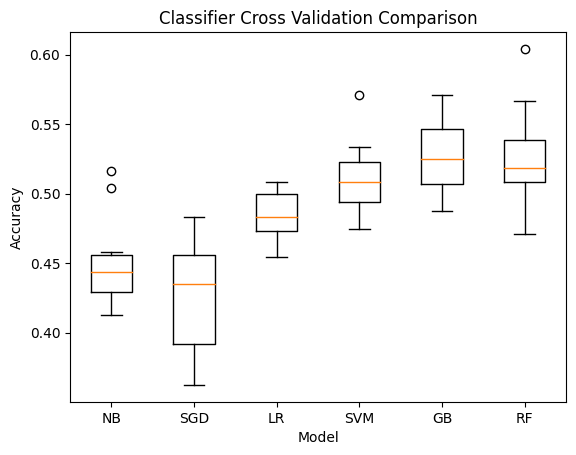

In [14]:
# We remove the Dummy classifier as it performs so much lower that it make the graph hard to read
plt_results = result_ST[1:]
plt_names = model_name_abrv[1:]

# Let's plot our results to visually see the difference
fig = plt.figure()
ax = fig.add_subplot()
plt.boxplot(plt_results)
ax.set_xticklabels(plt_names)
ax.set_title('Classifier Cross Validation Comparison')
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.show()

In the above cell we found that the Support Vector Machine (SVM), Gradient Boost (GB), and Random Forest (RF) models outpreform baseline logistic regression, SGD, and Naive Bayes classifers. In each case, we could see increased performance through model tuning, however we choose to only tune a RF given the better performance and runtime compared to the other.

# Feature Selection

Now that we have decided on using a Random Forest model, lets take a look at what impact each of the features have on the outcome. The purpose of this is to help optimize the hyper parameter tuning in the next section, as the method we will be using takes a considerable amount of time.

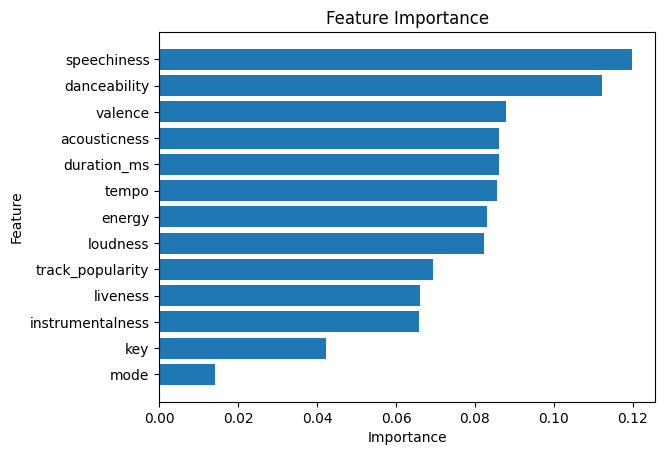

[0.06926555 0.11213338 0.08301705 0.04219714 0.08227687 0.01410228
 0.11972667 0.08608795 0.06573415 0.0659787  0.08779111 0.0856052
 0.08608395]


In [15]:
import matplotlib.pyplot as plt

rf = RandomForestClassifier().fit(X_train,y_train)

features = X.head().columns

f_i = list(zip(features,rf.feature_importances_))
f_i.sort(key = lambda x : x[1])
plt.barh([x[0] for x in f_i],[x[1] for x in f_i])
plt.title('Feature Importance')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()
print(rf.feature_importances_)

Here we see that every feature we used has some impact on the model, but some like mode or key have a considerably smaller impact. Before we cut them out, let's test how their inclusion effects the accuracy and run time.

In [16]:
# Removing mode from one training set
X_train2, X_test2, y_train2, y_test2 = train_test_split(X.drop(['mode'], axis=1), y, test_size=0.2, random_state=42)

# Checking impact of dropping mode on both accuacy and runtime
time1 = time.time()
rf = RandomForestClassifier().fit(X_train,y_train)
time2 = time.time()
rf2 = RandomForestClassifier().fit(X_train2,y_train)
time3 = time.time()

print('Accuracy and train time with mode:', str(round(rf.score(X_test, y_test),3))+',', str(round(time2-time1,2))+'s')
print('Accuracy and train time without mode:', str(round(rf2.score(X_test2, y_test2),3))+',', str(round(time3-time2,2))+'s')

Accuracy and train time with mode: 0.546, 0.75s
Accuracy and train time without mode: 0.532, 0.77s


Even though 'mode' has minimal impact on the accuracy of the model, it also has minimum impact on runtime. Although in the next section we will be doing feature tuning on the mode, which takes a long time, we will keep 'mode' in the feature set.

## Random Forest Model Tuning

To set our baseline expectations, we creation and fit a default random forest model and print out it's score and confusion matrix. From there, we can compare the default against an optimized model found by using sklearns Grid Search function.

In [17]:
# Calculate Score
score = rf.score(X_test, y_test)
print(score)

# Display confusion matrix
confusion_matrix(rf.predict(X_test), y_test)

0.5457570715474209


array([[38,  1,  9,  2,  3,  1],
       [ 1, 19,  7,  7,  2,  1],
       [23, 22, 60, 21, 10, 20],
       [ 1,  8,  9, 59, 13, 11],
       [ 4, 14, 13, 25, 70,  1],
       [ 5,  3, 19, 15,  2, 82]])

## Grid Search Initializing

<font color='red'>WARNING! The next cell takes a long time to run depending on grid parameters. If run as is, runtime will likely exceed 1 hour.</font>

In [18]:
import warnings
warnings.filterwarnings("ignore")

# To begin our grid search, we initizlize a dictionary with the random forest's parameters as keys, and the
# values we want to test as values.
grid_parameters = {
    'n_estimators': [10,50,100, 250, 500],
    'criterion' :['gini', 'entropy', 'log_loss'],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [5,10,25,34,50] # 34 was the max depth in our base example
    #,"bootstrap": [True, False]

}

# This is the chunck that takes the longest. We pass the classifer type, and parameters into the function to grid seach.
# Verbose only impacts what is displayed, setting it to 3 gives us the score of each test.
# In this case, we use cv=2, that means each parameter will get 1 tests. Increasing this extends runtime significantly.
grid = GridSearchCV(RandomForestClassifier(), grid_parameters, verbose=3, cv=2)
grid.fit(X_train,y_train)

print(grid.best_estimator_)

Fitting 2 folds for each of 225 candidates, totalling 450 fits
[CV 1/2] END criterion=gini, max_depth=5, max_features=auto, n_estimators=10;, score=0.470 total time=   0.0s
[CV 2/2] END criterion=gini, max_depth=5, max_features=auto, n_estimators=10;, score=0.456 total time=   0.1s
[CV 1/2] END criterion=gini, max_depth=5, max_features=auto, n_estimators=50;, score=0.482 total time=   0.2s
[CV 2/2] END criterion=gini, max_depth=5, max_features=auto, n_estimators=50;, score=0.492 total time=   0.2s
[CV 1/2] END criterion=gini, max_depth=5, max_features=auto, n_estimators=100;, score=0.488 total time=   0.3s
[CV 2/2] END criterion=gini, max_depth=5, max_features=auto, n_estimators=100;, score=0.492 total time=   0.3s
[CV 1/2] END criterion=gini, max_depth=5, max_features=auto, n_estimators=250;, score=0.485 total time=   0.8s
[CV 2/2] END criterion=gini, max_depth=5, max_features=auto, n_estimators=250;, score=0.493 total time=   0.8s
[CV 1/2] END criterion=gini, max_depth=5, max_feature

In [19]:
# It's Done! Lets check out what our best parameters were.
print(grid.best_score_)
print(grid.best_params_)

0.5270833333333333
{'criterion': 'entropy', 'max_depth': 25, 'max_features': 'auto', 'n_estimators': 250}


From here we can see that using gini as our criterion, log2 as our matx features, and max depth and n_esimators set to 50, and 500 respectivly has the best result. Lets run the model with those parameters and get out a score.

In [20]:
grid_predictions = grid.predict(X_test)
print(confusion_matrix(y_test,grid_predictions))
print(classification_report(y_test,grid_predictions))

[[35  0 23  1  5  8]
 [ 1 14 27  6 17  2]
 [ 5  8 60  9 15 20]
 [ 2  3 22 54 28 20]
 [ 2  2  9  9 75  3]
 [ 2  0 17  9  3 85]]
              precision    recall  f1-score   support

         edm       0.74      0.49      0.59        72
       latin       0.52      0.21      0.30        67
         pop       0.38      0.51      0.44       117
         r&b       0.61      0.42      0.50       129
         rap       0.52      0.75      0.62       100
        rock       0.62      0.73      0.67       116

    accuracy                           0.54       601
   macro avg       0.57      0.52      0.52       601
weighted avg       0.56      0.54      0.53       601



Through out grid search, we found that the best accuracy achieved by a random forest model was ~0.574. This score was achieved with the parameter settings: 'criterion': 'gini', 'max_depth': 50, 'max_features': 'auto', 'n_estimators': 500. Although this score is slightly better than the base random forest model, and significantly better than random guessing, it is still not as high as we would like to see. Moving forward, we want to appraoch song genre classification in a new way, using a song's MIDI file.

## Sample Size Testing

Now that we have a finalized model, we want to confirm it's resiliancy to new data. To do this there are a few indicators we can check. In the cells above this one, we affirmed that different hyper parameter settings and the different features aren't to sensitive, which is a good sign for overall resiliancy. Now, we want to check if we are using a good amount of data to prove that new data introduced in the future wont cause to much sway. To do this we run our model on different sample sizes and plot their accuracy.

In [21]:
# Initialize our lists that will be plotted
sample_sizes = []
scores = []
st_devs = []

# Run through different sample sizes, starting at 1,000 and incrementing up by 1,000 until we hit 14,000
for n in np.linspace(len(X_train)/10, len(X_train), 10).astype(int):

    # Creating the subsamples of our training data
    selected_indexes = np.random.choice(len(X_train), n, False)
    y_sub_train = y_train.iloc[selected_indexes]
    X_sub_train = X_train[selected_indexes]

    # Create a model using the best hyperparameters found during the grid search
    rf_sub = RandomForestClassifier(n_estimators=500, criterion='gini', max_depth=50, random_state=42, n_jobs=-1)
    cv_score = cross_val_score(rf_sub, X_sub_train, y_sub_train, cv = 10, scoring = 'accuracy')

    # Retrieve our evaluation metrics for this iteration
    cv_mean = cv_score.mean()
    cv_std = cv_score.std()

    # Add our values to our lists to be plotted
    sample_sizes.append(n)
    scores.append(cv_mean)
    st_devs.append(cv_std)

    # Print out the scores to see if accuracy is progressing
    print('Sample size:', n, 'Score:', round(cv_score.mean(),3))

Sample size: 240 Score: 0.525
Sample size: 480 Score: 0.496
Sample size: 720 Score: 0.481
Sample size: 960 Score: 0.481
Sample size: 1200 Score: 0.513
Sample size: 1440 Score: 0.532
Sample size: 1680 Score: 0.523
Sample size: 1920 Score: 0.523
Sample size: 2160 Score: 0.528
Sample size: 2400 Score: 0.534


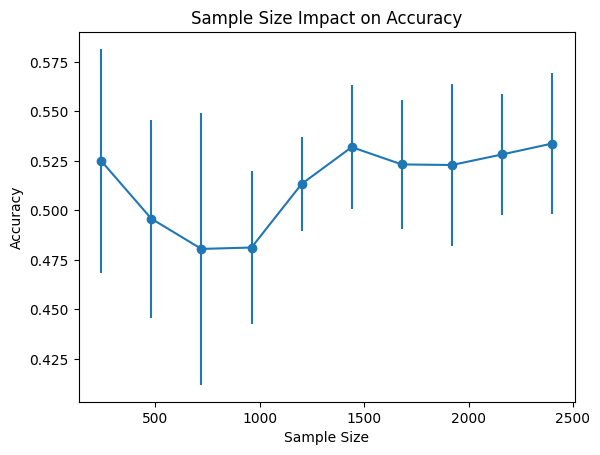

In [22]:
# Using an error bar graph, we can see the progression of accuracy, and the shrinking standard deviation as n increases
plt.errorbar(sample_sizes, scores, st_devs, marker = 'o')
plt.title('Sample Size Impact on Accuracy')
plt.xlabel("Sample Size")
plt.ylabel("Accuracy")
plt.show()